# Data Smoothing

Does smoothing data improve model performance?

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from keras.models import load_model

import scipy
from scipy import stats

In [25]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
    ]
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

## Using unsmoothed data

In [59]:
#pulse_data = pd.read_csv("../JET_EFIT_magnetic/all.csv")
# I should smooth each curve individually
pulse_data = pd.read_csv("../JET_EFIT_magnetic/99002.csv")

In [60]:
pulse_data = pulse_data.dropna(axis=0)

y = pulse_data[["FBND", "FAXS"]]
X = pulse_data.drop(["FBND-FAXS", "FAXS", "FBND", "Time"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=24
)

FEATURES = 40
N_VALIDATION = int(len(X_val))
N_TRAIN = int(len(X_train))
BUFFER_SIZE = N_TRAIN
BATCH_SIZE = 100  # can crank this up
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, decay_steps=STEPS_PER_EPOCH * 1000, decay_rate=1, staircase=False
)


def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)


normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))


In [61]:
tiny_model = tf.keras.Sequential(
    [   normalizer,
        layers.Dense(12, input_shape=(FEATURES,)),
        layers.LeakyReLU(alpha=0.3),
        layers.Dropout(0.6),
        layers.Dense(128, activation="relu"),
        layers.Dense(10),
        layers.Dense(2),
    ]
)

optimizer = get_optimizer()

tiny_model.compile(
    optimizer=optimizer,
    loss="mean_absolute_error",
    metrics="mean_absolute_percentage_error",
)
print(tiny_model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 40)                81        
_________________________________________________________________
dense_36 (Dense)             (None, 12)                492       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 12)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               1664      
_________________________________________________________________
dense_38 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_39 (Dense)             (None, 2)                

In [62]:
tiny_model.fit(
    X_train,
    y_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[get_callbacks()],
    verbose=1,
)


Epoch 1/20
6/6 [==============================] - 1s 25ms/step - loss: 1.1948 - mean_absolute_percentage_error: 660.6337 - val_loss: 1.1421 - val_mean_absolute_percentage_error: 108.6079
Epoch 2/20
6/6 [==============================] - 0s 4ms/step - loss: 1.0459 - mean_absolute_percentage_error: 1645.3430 - val_loss: 1.0239 - val_mean_absolute_percentage_error: 107.2855
Epoch 3/20
6/6 [==============================] - 0s 4ms/step - loss: 0.9043 - mean_absolute_percentage_error: 247.4473 - val_loss: 0.9513 - val_mean_absolute_percentage_error: 121.0215
Epoch 4/20
6/6 [==============================] - 0s 4ms/step - loss: 0.8931 - mean_absolute_percentage_error: 1057.0497 - val_loss: 0.9056 - val_mean_absolute_percentage_error: 131.1434
Epoch 5/20
6/6 [==============================] - 0s 4ms/step - loss: 0.9079 - mean_absolute_percentage_error: 3021.8728 - val_loss: 0.8846 - val_mean_absolute_percentage_error: 132.2687
Epoch 6/20
6/6 [==============================] - 0s 4ms/step - lo

In [63]:
tiny_model.evaluate(X_test, y_test, verbose=2)


7/7 - 0s - loss: 0.7543 - mean_absolute_percentage_error: 113.2689


[0.7543152570724487, 113.26890563964844]

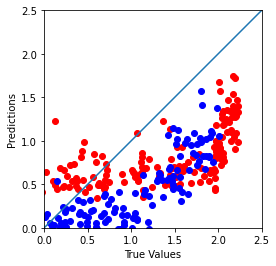

In [66]:
y_pred = tiny_model.predict(X_test)

a = plt.axes(aspect="equal")
plt.scatter(y_test.iloc[:, 0], y_pred[:, 0], color="red")
plt.scatter(y_test.iloc[:, 1], y_pred[:, 1], color="blue")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 2.5]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)
plt.show()

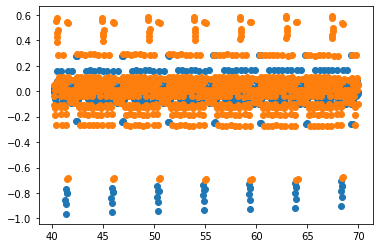

In [70]:
unsmoothed = pd.read_csv("../JET_EFIT_magnetic/99002.csv")

plt.scatter(unsmoothed["Time"], unsmoothed["FLME_7"])
plt.scatter(unsmoothed["Time"], unsmoothed["FLME_37"])


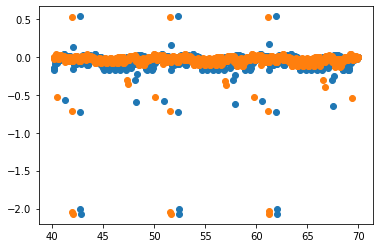

In [69]:
plt.scatter(unsmoothed["Time"], unsmoothed["BPME_13"])
plt.scatter(unsmoothed["Time"], unsmoothed["BPME_10"])

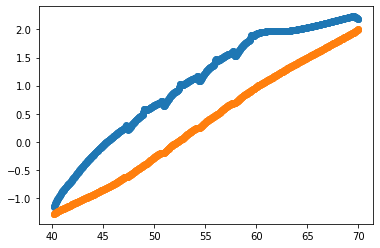

In [68]:
plt.scatter(unsmoothed["Time"], unsmoothed["FBND"])
plt.scatter(unsmoothed["Time"], unsmoothed["FAXS"])

## Data Smoothing Approaches
Can do multi or univariate smoothing. 

For simplicity will start with univariate smoothing, focus on the FAXS or FBND (either fine- target variable). Then apply same approach to all the other variables.

### Bin Smoothing

Cuts domain into bins, dumps values into bins and sets them to average of data in that bin (or median or boundary value). 

Note: this assumes each value can be equally weighted. Fine here because each value along x-axis is a 0.03 second timestep. Would not be valid otherwise.

In [ ]:
x_axis = unsmoothed["Time"]
values_to_bin = unsmoothed["BPME_13"]

### Moving Average

### Running Line

### Kernel Density

### LOESS

### Smoothing Splines